In [315]:
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
import os
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from typing import Annotated,Literal
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [316]:
load_dotenv()

True

In [317]:
#  Initialize Endpoint with the correct task
llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.1-8B-Instruct",
    task="text-generation",  
    
)

# 3. Wrap in Chat Interface
model = ChatHuggingFace(llm=llm)

In [318]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [319]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [320]:
# Define the Graph
graph=StateGraph(TweetState)

In [321]:
# 1. Define the Strict Pydantic Schema
class TweetEvaluation(BaseModel):
    """Structured evaluation of a tweet draft."""
    evaluation: Literal["approved", "needs_improvement"] = Field(
        description="Must be 'approved' if the tweet meets all criteria, otherwise 'needs_improvement'."
    )
    feedback: str = Field(
        description="One paragraph explaining the strengths and weaknesses of the tweet based on the criteria."
    )

# 2. Initialize the Parser and Get Instructions
parser = JsonOutputParser(pydantic_object=TweetEvaluation)
FORMAT_INSTRUCTIONS = parser.get_format_instructions()

In [322]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal['approved','needs_improvement']
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [323]:
def generate_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = model.invoke(messages).content
    return {'tweet': response, 'tweet_history': [response]}


In [324]:
def evaluate_tweet(state: TweetState):
    # The full instruction set, including the parser's strict format instructions
    evaluation_prompt_content = f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)

### Respond ONLY in structured JSON format:
{FORMAT_INSTRUCTIONS}
"""

    messages = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format. Your ONLY output is a JSON object."),
        HumanMessage(content=evaluation_prompt_content)
    ]
    
    # 1. Invoke the model to get the raw string content (which should be JSON)
    # Note: 'model' is assumed to be your ChatHuggingFace instance
    response_string = model.invoke(messages).content
    
    # 2. CRITICAL STEP: Parse the raw string into the Pydantic object
    try:
        parsed_response = parser.parse(response_string)
    except Exception as e:
        # Robustness for free models: handle potential parsing errors
        print(f"Failed to parse LLM output: {e}")
        print(f"Raw response: {response_string}")
        # In a real LangGraph loop, this would route to a retry node!
        return {'evaluation': 'needs_improvement', 'feedback': 'Parsing error: LLM did not output valid JSON. Try again.'}

    # 3. Handle both dict and Pydantic object returns from parser
    if isinstance(parsed_response, dict):
        evaluation = parsed_response.get('evaluation', 'needs_improvement')
        feedback = parsed_response.get('feedback', 'Could not extract feedback.')
    else:
        # Pydantic object case
        evaluation = parsed_response.evaluation
        feedback = parsed_response.feedback

    return {
        'evaluation': evaluation, 
        'feedback': feedback,
        'feedback_history': [feedback]
    }


In [325]:
def optimize_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
    Improve the tweet based on this feedback:
    "{state['feedback']}"

    Topic: "{state['topic']}"
    Original Tweet:
    {state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    response = model.invoke(messages).content
    iteration = state['iteration'] + 1
    return {'tweet': response, 'iteration': iteration,'tweet_history': [response]}

In [326]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [327]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

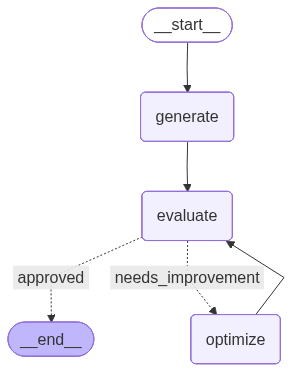

In [328]:
workflow = graph.compile()

workflow

In [331]:
initial_state = {
    "topic": "Bangladesh Cricket",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [332]:
result

{'topic': 'Bangladesh Cricket',
 'tweet': '"Just saw the Bangladesh cricket team win a game, now the whole country is shut down, I guess they didn\'t wanna risk losing to traffic jams #BANvIND"',
 'evaluation': 'approved',
 'feedback': "This tweet effectively uses understatement to convey an unexpected event with a witty observation. It's original and concise, maintaining an amusing tone throughout. The hashtag adds context and relevance to the joke, increasing its virality potential. This tweet meets all the criteria, making it suitable for sharing.",
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['"Just saw the Bangladesh cricket team win a game, now the whole country is shut down, I guess they didn\'t wanna risk losing to traffic jams #BANvIND"'],
 'feedback_history': ["This tweet effectively uses understatement to convey an unexpected event with a witty observation. It's original and concise, maintaining an amusing tone throughout. The hashtag adds context and relevance t